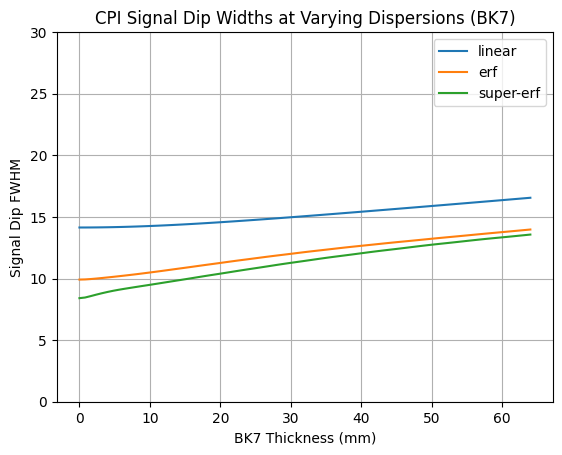

In [ ]:
import numpy as np
from scipy.optimize import minimize 
import math
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import matplotlib.ticker as ticker


linear_dip_widths = []
erf_dip_widths = []
super_erf_dip_widths = []

linear_chi2 = []
erf_chi2 = []
super_erf_chi2 = []

folder_name = "freshwater_dispersion"

# --- Initial guesses ---
init_guess_parabolic = [0, 0.0025, 0.00000001, 0.9, 10]
init_guess = [0, 0.0025, 0.9, 10]

Lvals = np.arange(0, 64001, 800)
Lvals2 = [0, 800]
taus = np.arange(-100, 100 + 0.5, 0.5)

def one_minus_gaussian(t, t_0, a1, a2, fwhm):
    return a1 - a2*np.exp(-4*np.log(2)*((t - t_0)**2)/fwhm**2)

def parabolic_one_minus_gaussian(t, t_0, a1, a2, a3, fwhm):
    return (a1 - a2*(t - t_0)**2)*(1 - a3*np.exp(-4*math.log(2)*((t - t_0)**2)/fwhm**2))

def chisq(params, t, y):
    t0, a1, a2, fwhm = params
    model = one_minus_gaussian(t, t0, a1, a2, fwhm)
    return np.sum((y - model)**2)

def chisq_parabolic(params, t, y):
    t0, a1, a2, a3, fwhm = params
    model = parabolic_one_minus_gaussian(t, t0, a1, a2, a3, fwhm)
    return np.sum((y - model)**2)

def residuals_parabolic(params, t, y):
    T0, a1, a2, a3, sigma = params
    model = (a1 - a2 * (t - T0)**2) * (1 - a3 * np.exp(-4 * np.log(2) * (t - T0)**2 / sigma**2))
    return model - y

def residuals(params, t, y):
    T0, a1, a2, sigma = params
    model = (a1 - a2 * np.exp(-4 * np.log(2) * (t - T0)**2 / sigma**2))
    return model - y

for L in Lvals:
    '''lin_sig = np.loadtxt(f"./test_results/linear/linear_L{L}.txt")
    erf_sig = np.loadtxt(f"./test_results/erf/erf_L{L}.txt")
    superf_sig = np.loadtxt(f"./test_results/super_erf/super_erf_L{L}.txt")'''
    init_guess = [0, 0.0002*L, 0.9, 10]

    lin_sig = np.loadtxt(f"./{folder_name}/linear/linear_L{L}.txt")
    erf_sig = np.loadtxt(f"./{folder_name}/erf/erf_L{L}.txt")
    superf_sig = np.loadtxt(f"./{folder_name}/super_erf/super_erf_L{L}.txt")

    lin_norm = (lin_sig - np.min(lin_sig))/(np.max(lin_sig) - np.min(lin_sig))
    erf_norm = (erf_sig - np.min(erf_sig))/(np.max(erf_sig) - np.min(erf_sig))
    superf_norm = (superf_sig - np.min(superf_sig))/(np.max(superf_sig) - np.min(superf_sig))
    
    # --- Fit the data ---
    #lin_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, lin_norm), method='L-BFGS-B')
    #erf_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, erf_norm), method='L-BFGS-B')
    #superf_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, superf_norm), method='L-BFGS-B')

    #pretty sure maggies code uses the LevenbergMarquardt method, at least for the 0 dispersion dip
    lin_result = least_squares(residuals, init_guess, args=(taus, lin_sig), method='lm', 
                               ftol=1e-15, xtol=1e-15, gtol=1e-15)
    erf_result = least_squares(residuals, init_guess, args=(taus, erf_sig), method='lm',
                               ftol=1e-15, xtol=1e-15, gtol=1e-15)
    superf_result = least_squares(residuals, init_guess, args=(taus, superf_sig), method='lm', 
                               ftol=1e-15, xtol=1e-15, gtol=1e-15)
    
    '''
    if (L == 0):
        print(np.sum(lin_result.fun**2))
        print(np.sum(erf_result.fun**2))
        print(np.sum(superf_result.fun**2))
    '''

    '''
    linear_chi2.append(chisq(lin_result.x, taus, lin_norm))
    erf_chi2.append(chisq(erf_result.x, taus, erf_norm))
    super_erf_chi2.append(chisq(superf_result.x, taus, superf_norm))
    '''
    linear_chi2.append(lin_result.cost)
    erf_chi2.append(erf_result.cost)
    super_erf_chi2.append(superf_result.cost)


    linear_dip_widths.append(lin_result.x[3])
    erf_dip_widths.append(erf_result.x[3])
    super_erf_dip_widths.append(superf_result.x[3]) 
'''
print(linear_dip_widths[0])
print(erf_dip_widths[0])
print(super_erf_dip_widths[0])
'''
#np.savetxt(f"./linear_dip_widths.txt", linear_dip_widths, )
plt.plot(Lvals, linear_dip_widths, label = "linear")
plt.plot(Lvals, erf_dip_widths, label = "erf")
plt.plot(Lvals, super_erf_dip_widths, label = "super-erf")
plt.xlabel("BK7 Thickness (mm)")
plt.ylabel("Signal Dip FWHM")
plt.legend()
plt.grid()
plt.title(f'CPI Signal Dip Widths at Varying Dispersions ({folder_name})')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))

plt.ylim(0, 30);

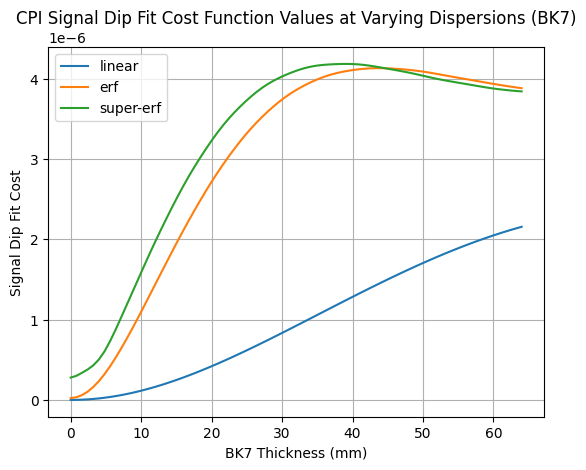

In [ ]:
plt.plot(Lvals, linear_chi2, label = "linear")
plt.plot(Lvals, erf_chi2, label = "erf")
plt.plot(Lvals, super_erf_chi2, label = "super-erf")
plt.xlabel("BK7 Thickness (mm)")
plt.ylabel("Signal Dip Fit Cost")
plt.legend()
plt.grid()
plt.title(f'CPI Signal Dip Fit Cost Function Values at Varying Dispersions ({folder_name})')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))

Chi squared makes no sense for computing error of this - of course its going to have bad values as you increase L because youre fitting a Gaussian to something with ringing. What would a better way of doing this? ideally you want the chi squared just around the curve region because thats the only part of the fit you care about

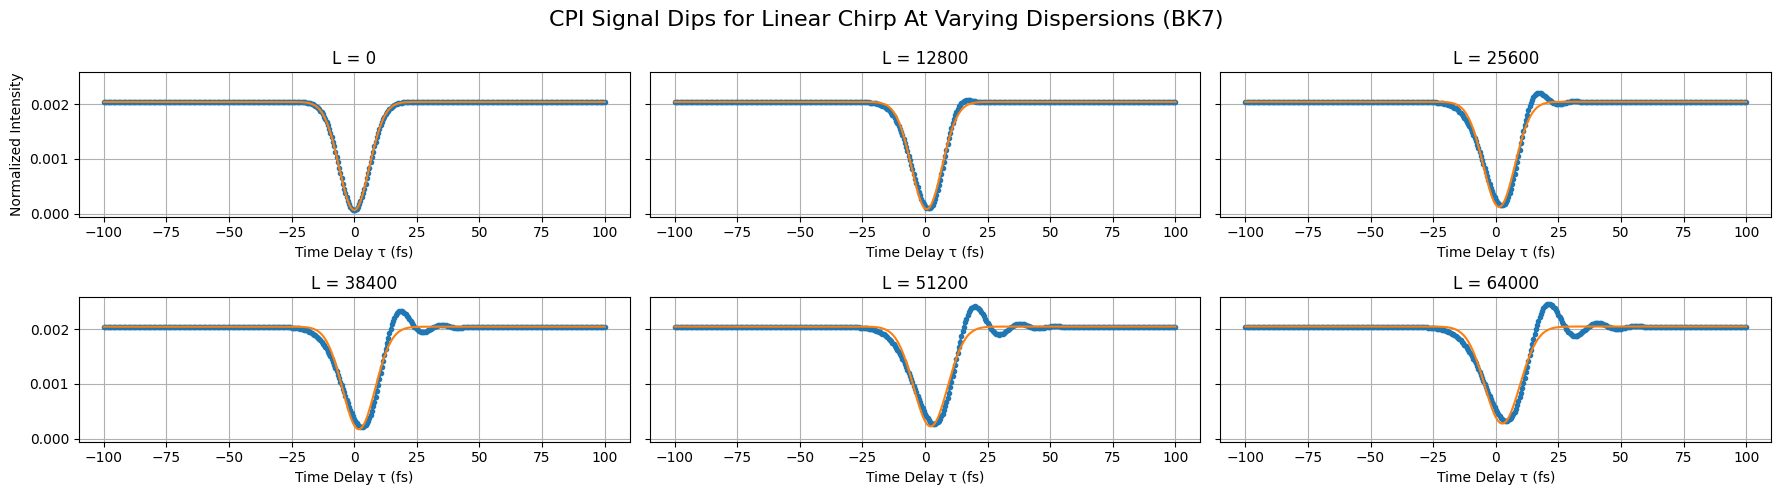

In [ ]:
lin_signals = []
lin_curves = []

Ls = [0, 12800, 25600, 38400, 51200, 64000]
titles = ['L = 0', 'L = 12800', 'L = 25600', 'L = 38400', 'L = 51200', 'L = 64000']

for L in Ls:
    
    init_guess = [0.0002*L, 0.0025, 0.9, 10]

    lin_sig = np.loadtxt(f"./{folder_name}/linear/linear_L{L}.txt")
    lin_norm = (lin_sig - np.min(lin_sig))/(np.max(lin_sig) - np.min(lin_sig))
    
    lin_signals.append(lin_sig)

    lin_result = least_squares(residuals, init_guess, args=(taus, lin_sig), method='lm', 
                                ftol=1e-15, xtol=1e-15, gtol=1e-15)
    params = lin_result.x

    lin_curves.append(one_minus_gaussian(taus, params[0], params[1], params[2], params[3]))
    

#complete_titles = ["Linear CPI", "ERF CPI", "Super ERF CPI", "Linear CPI - Parabolic", "ERF CPI - Parabolic", "Super ERF CPI - Parbolic"]
# --- Create subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

axes = axes.flatten()

for ax, signal, curve, name in zip(axes, lin_signals, lin_curves, titles):
    ax.plot(taus, signal, marker=".")
    ax.plot(taus, curve)
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(name)
    ax.grid(True)

    # --- Optional: print fitted parameters ---
    #print(f"Fitted parameters for {name}: a = {param[0]:.4f}, t0 = {param[1]:.4f} fs, FWHM = {param[2]:.4f} fs")
    
axes[0].set_ylabel('Normalized Intensity')
fig.suptitle(f"CPI Signal Dips for Linear Chirp At Varying Dispersions ({folder_name})", fontsize=16)
plt.tight_layout()
plt.show();

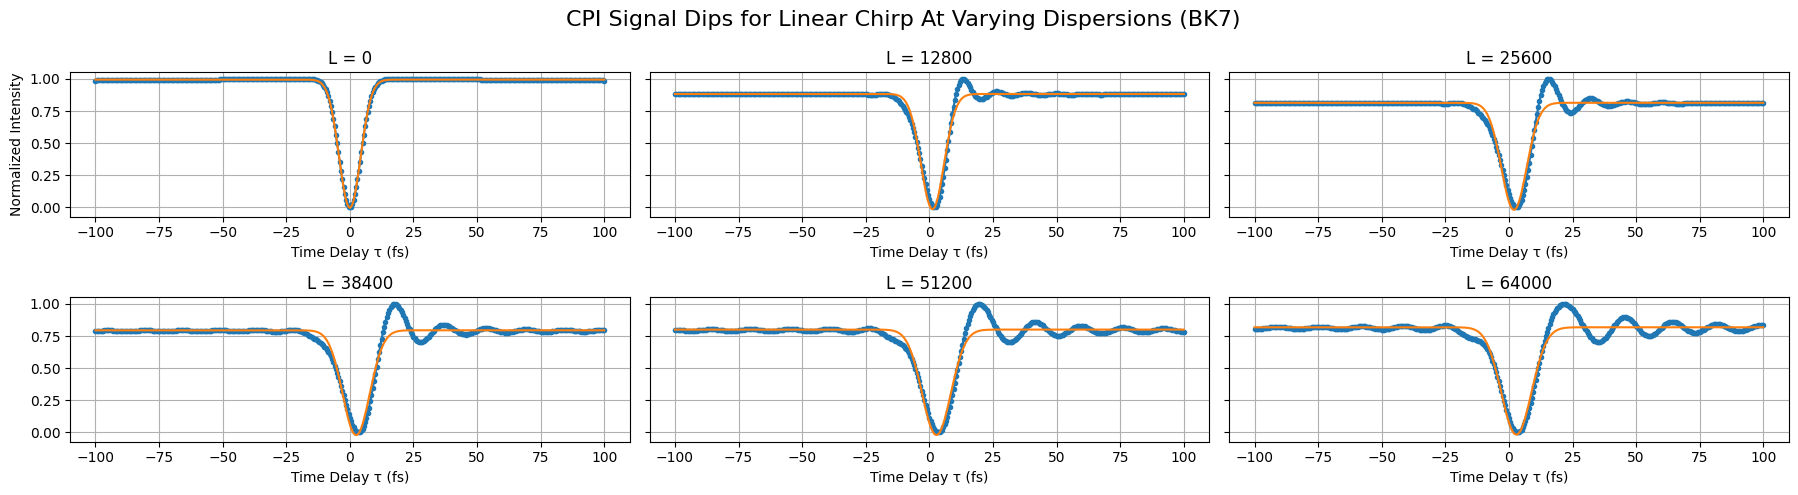

In [ ]:
erf_signals = []
erf_curves = []

Ls = [0, 12800, 25600, 38400, 51200, 64000]
titles = ['L = 0', 'L = 12800', 'L = 25600', 'L = 38400', 'L = 51200', 'L = 64000']

for L in Ls:
    
    init_guess = [0.0002*L, 0.0025, 0.9, 10]

    erf_sig = np.loadtxt(f"./{folder_name}/erf/erf_L{L}.txt")
    erf_norm = (erf_sig - np.min(erf_sig))/(np.max(erf_sig) - np.min(erf_sig))
    
    erf_signals.append(erf_norm)

    erf_result = least_squares(residuals, init_guess, args=(taus, erf_norm), method='lm', 
                                ftol=1e-15, xtol=1e-15, gtol=1e-15)
    params = erf_result.x

    erf_curves.append(one_minus_gaussian(taus, params[0], params[1], params[2], params[3]))
    

#complete_titles = ["Linear CPI", "ERF CPI", "Super ERF CPI", "Linear CPI - Parabolic", "ERF CPI - Parabolic", "Super ERF CPI - Parbolic"]
# --- Create subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

axes = axes.flatten()

for ax, signal, curve, name in zip(axes, erf_signals, erf_curves, titles):
    ax.plot(taus, signal, marker=".")
    ax.plot(taus, curve)
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(name)
    ax.grid(True)

    # --- Optional: print fitted parameters ---
    #print(f"Fitted parameters for {name}: a = {param[0]:.4f}, t0 = {param[1]:.4f} fs, FWHM = {param[2]:.4f} fs")
    
axes[0].set_ylabel('Normalized Intensity')
fig.suptitle(f"CPI Signal Dips for Erf Chirp At Varying Dispersions ({folder_name})", fontsize=16)
plt.tight_layout()
plt.show();

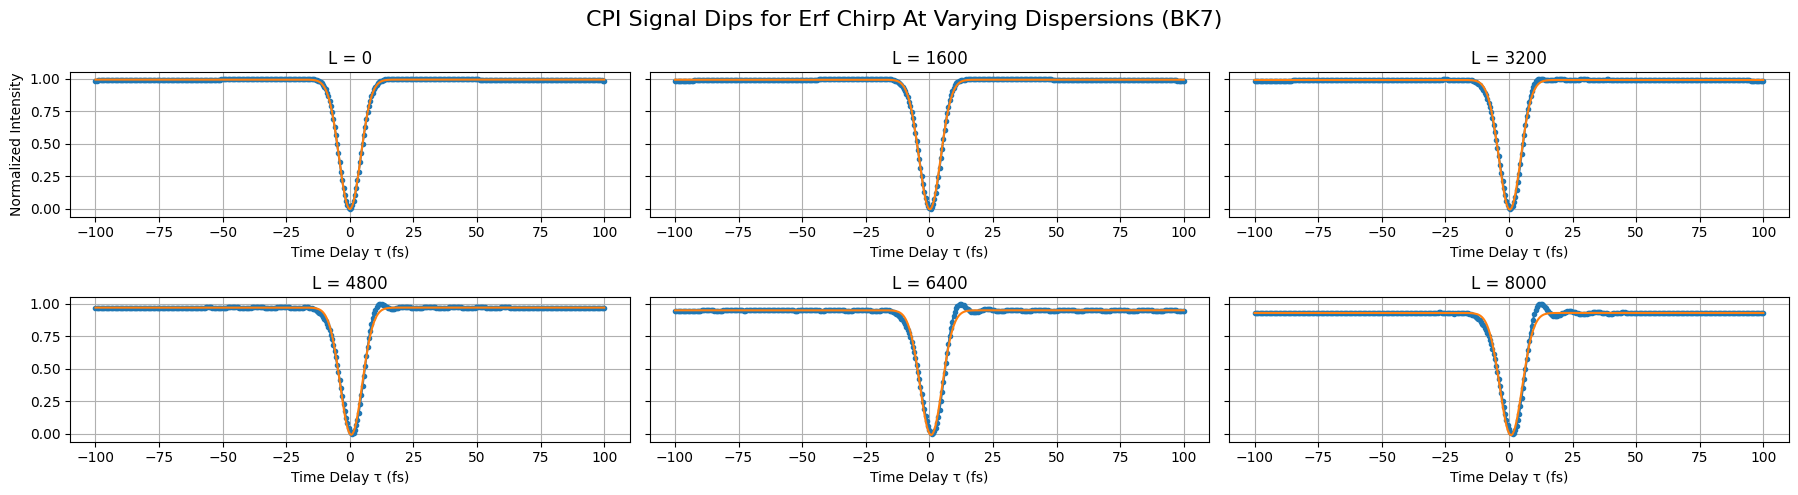

In [ ]:
erf_signals = []
erf_curves = []

Ls = [0, 1600, 3200, 4800, 6400, 8000]
titles = ['L = 0', 'L = 1600', 'L = 3200', 'L = 4800', 'L = 6400', 'L = 8000']

for L in Ls:
    
    init_guess = [0.0002*L, 0.0025, 0.9, 10]

    erf_sig = np.loadtxt(f"./{folder_name}/erf/erf_L{L}.txt")
    erf_norm = (erf_sig - np.min(erf_sig))/(np.max(erf_sig) - np.min(erf_sig))
    
    erf_signals.append(erf_norm)

    erf_result = least_squares(residuals, init_guess, args=(taus, erf_norm), method='lm', 
                                ftol=1e-15, xtol=1e-15, gtol=1e-15)
    params = erf_result.x

    erf_curves.append(one_minus_gaussian(taus, params[0], params[1], params[2], params[3]))
    

#complete_titles = ["Linear CPI", "ERF CPI", "Super ERF CPI", "Linear CPI - Parabolic", "ERF CPI - Parabolic", "Super ERF CPI - Parbolic"]
# --- Create subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

axes = axes.flatten()

for ax, signal, curve, name in zip(axes, erf_signals, erf_curves, titles):
    ax.plot(taus, signal, marker=".")
    ax.plot(taus, curve)
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(name)
    ax.grid(True)

    # --- Optional: print fitted parameters ---
    #print(f"Fitted parameters for {name}: a = {param[0]:.4f}, t0 = {param[1]:.4f} fs, FWHM = {param[2]:.4f} fs")
    
axes[0].set_ylabel('Normalized Intensity')
fig.suptitle(f"CPI Signal Dips for Erf Chirp At Varying Dispersions ({folder_name})", fontsize=16)
plt.tight_layout()
plt.show();

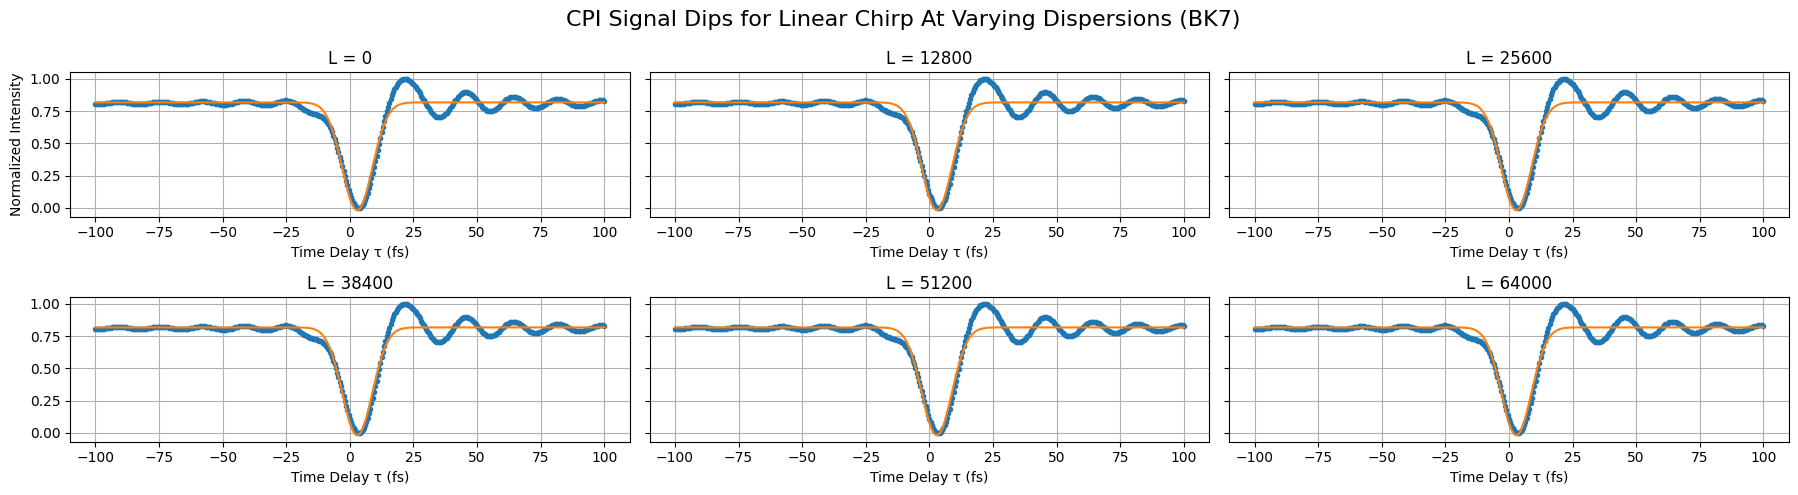

In [ ]:
super_erf_signals = []
super_erf_curves = []

Ls = [0, 12800, 25600, 38400, 51200, 64000]
titles = ['L = 0', 'L = 12800', 'L = 25600', 'L = 38400', 'L = 51200', 'L = 64000']

for L in Ls:
    
    init_guess = [0.0002*L, 0.0025, 0.9, 10]

    super_erf_sig = np.loadtxt(f"./{folder_name}/erf/erf_L{L}.txt")
    super_erf_norm = (erf_sig - np.min(erf_sig))/(np.max(erf_sig) - np.min(erf_sig))
    
    super_erf_signals.append(erf_norm)

    super_erf_result = least_squares(residuals, init_guess, args=(taus, super_erf_norm), method='lm', 
                                ftol=1e-15, xtol=1e-15, gtol=1e-15)
    params = super_erf_result.x

    super_erf_curves.append(one_minus_gaussian(taus, params[0], params[1], params[2], params[3]))
    

# --- Create subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

axes = axes.flatten()

for ax, signal, curve, name in zip(axes, super_erf_signals, super_erf_curves, titles):
    ax.plot(taus, signal, marker=".")
    ax.plot(taus, curve)
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(name)
    ax.grid(True)

    # --- Optional: print fitted parameters ---
    #print(f"Fitted parameters for {name}: a = {param[0]:.4f}, t0 = {param[1]:.4f} fs, FWHM = {param[2]:.4f} fs")
    
axes[0].set_ylabel('Normalized Intensity')
fig.suptitle(f"CPI Signal Dips for Super Erf Chirp At Varying Dispersions ({folder_name})", fontsize=16)
plt.tight_layout()
plt.show();

In [2]:
import sys
print(sys.executable)

c:\Program Files\Python39\python.exe


5.198771420117937e-16
2.362980033607251e-05
0.001697415065674777
14.142114756407269
10.001714131193529
8.695071722856943


(0.0, 30.0)

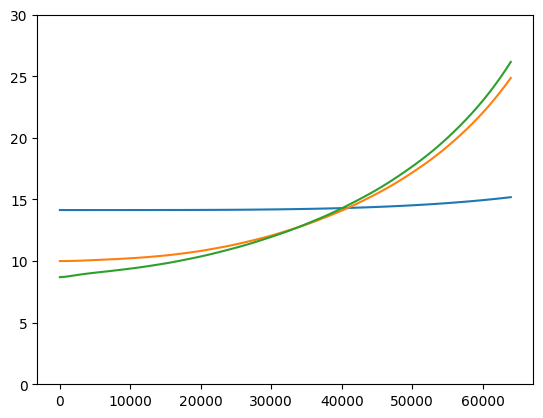

In [7]:
#attempting with jax now!
import jax
import jax.numpy as jnp
from jax import jit, jacrev
import numpy as np
from scipy.optimize import least_squares
from jax import config 
config.update("jax_enable_x64", True)

def model(params, t):
    T0, a1, a2, a3, sigma = params
    return (a1 - a2 * (t - T0)**2) * (1 - a3 * jnp.exp(-4 * jnp.log(2) * (t - T0)**2 / sigma**2))

def residuals(params, t, y):
    return model(params, t) - y

jacobian_fn = jit(jacrev(residuals))
x0 = jnp.array([0, 0.0025, 1e-8, 0.9, 10.0])

linear_dip_widths = []
erf_dip_widths = []
super_erf_dip_widths = []

for L in Lvals:
    '''lin_sig = np.loadtxt(f"./test_results/linear/linear_L{L}.txt")
    erf_sig = np.loadtxt(f"./test_results/erf/erf_L{L}.txt")
    superf_sig = np.loadtxt(f"./test_results/super_erf/super_erf_L{L}.txt")'''

    lin_sig = np.loadtxt(f"./transition docs copy/Mar7_results/lin_dips_mar7/dip_{L}.txt")
    erf_sig = np.loadtxt(f"./transition docs copy/Mar7_results/erf_dips_mar7/dip_{L}.txt")
    superf_sig = np.loadtxt(f"./transition docs copy/Mar7_results/super_dips_mar7/dip_{L}.txt")

    lin_norm = (lin_sig - np.min(lin_sig))/(np.max(lin_sig) - np.min(lin_sig))
    erf_norm = (erf_sig - np.min(erf_sig))/(np.max(erf_sig) - np.min(erf_sig))
    superf_norm = (superf_sig - np.min(superf_sig))/(np.max(superf_sig) - np.min(superf_sig))
    
    # --- Fit the data ---
    #lin_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, lin_norm), method='L-BFGS-B')
    #erf_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, erf_norm), method='L-BFGS-B')
    #superf_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, superf_norm), method='L-BFGS-B')

    #pretty sure maggies code uses the LevenbergMarquardt method, at least for the 0 dispersion dip
    lin_result = least_squares(
    fun=lambda p: np.array(residuals(p, taus, lin_norm)),
    x0=np.array(x0),
    jac=lambda p: np.array(jacobian_fn(p, taus, lin_norm)),
    method='trf',
    ftol=1e-14,
    xtol=1e-14,
    gtol=1e-14,
    verbose=0
)
    erf_result = least_squares(
    fun=lambda p: np.array(residuals(p, taus, erf_norm)),
    x0=np.array(x0),
    jac=lambda p: np.array(jacobian_fn(p, taus, erf_norm)),
    method='trf',
    ftol=1e-14,
    xtol=1e-14,
    gtol=1e-14,
    verbose=0
)
    superf_result = least_squares(
    fun=lambda p: np.array(residuals(p, taus, superf_norm)),
    x0=np.array(x0),
    jac=lambda p: np.array(jacobian_fn(p, taus, superf_norm)),
    method='trf',
    ftol=1e-14,
    xtol=1e-14,
    gtol=1e-14,
    verbose=0
)

    if (L == 0):
        print(np.sum(lin_result.fun**2))
        print(np.sum(erf_result.fun**2))
        print(np.sum(superf_result.fun**2))
    
    linear_dip_widths.append(lin_result.x[4])
    erf_dip_widths.append(erf_result.x[4])
    super_erf_dip_widths.append(superf_result.x[4]) 

print(linear_dip_widths[0])
print(erf_dip_widths[0])
print(super_erf_dip_widths[0])

np.savetxt(f"./linear_dip_widths.txt", linear_dip_widths, )
plt.plot(Lvals, linear_dip_widths, label = "linear")
plt.plot(Lvals, erf_dip_widths, label = "erf")
plt.plot(Lvals, super_erf_dip_widths, label = "super-erf")
plt.ylim(0, 30)